In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [29]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
with open('descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)
    
obj_names = []

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    obj_names.append(obj_name)
    
contiguous_names_short = [
    'Recpt\'n',
    'Drvway',
    'Aprtmnt',
    'Wrkst\'n',
    'Kitchen',
    'Hallway',
    'Strwell',
]

contiguous_names = [
    'Reception',
    'Driveway',
    'Apartment',
    'Workstation',
    'Kitchen',
    'Hallway',
    'Stairwell',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:olive",
    "tab:gray",
    "tab:pink",
    "tab:brown"
]

#obj_names
neighbor_sizes = 100*2**np.arange(0,6,2)
print(neighbor_sizes)

width = 0.01

[ 100  400 1600]


In [14]:
#RESULTS

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results_updated.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

  

# Comparing distrbutions of local vector similarity per partial spaces vs inference success.

# On NN-matcher over HoloLes data

In [15]:
# Per-submap spatial complexity score, i.e. norm vector similarity distribution at P(<)

with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(2.0), 'r') as bz2_f:
    norm_cdf_values = pickle.load(bz2_f)
    
per_sample_low_norm = []

for [obj_, object_name, original_vertex], per_space_values in norm_cdf_values:
    
    #if obj_ != 2: continue
    
    norm_cdf_ratios = [
        obj_,
        original_vertex[0],
        original_vertex[1],
        original_vertex[2]
    ]
    
    for hist, CY, values, hist_all, values_all, neighbor_size, len__ in per_space_values:
        
        np.sum(hist*values[1:])/np.sum(hist)
        
        norm_cdf_ratios.append(
            #neighbor_size,
            np.sum(hist[:92])/np.sum(hist)
            #np.sum(hist_all[:80])/np.sum(hist_all[80:-1]),
            #np.sum(hist_all[80:-1])/np.sum(hist_all[:80]),
            #np.sum(hist*values[1:])/np.sum(hist)
            #np.sum(hist[50:])/np.sum(hist[:50]),
        )
        
    per_sample_low_norm.append(norm_cdf_ratios)
    
per_sample_low_norm = np.asarray(per_sample_low_norm)


In [16]:
# Per-submap labelling at r = 2.0

radius = 2.0

try:
    with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'r') as bz2_f:
        partial_scores_pool = pickle.load(bz2_f) 

except:
    print("Error getting scores for",radius)
    
partial_errors_pool = NN_matcher(partial_scores_pool)
correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]
incorrect_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==1)[0]

nn_labels_partial_spaces = []

for i, [obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches] in enumerate(partial_scores_pool):

    #if i not in correct_interspace_labels_idxs: continue

    #if obj_meta[0] == 2 :
        
    nn_labels_partial_spaces.append([
        obj_meta[0],
        obj_meta[2][0],
        obj_meta[2][1],
        obj_meta[2][2],
        partial_errors_pool[i,-1]
    ])
        
nn_labels_partial_spaces = np.asarray(nn_labels_partial_spaces)

Plot for radius 2.0 and neighborhood size 400


"\nplt.savefig(\n    'properties/correct_vs_incorrect_low_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='pdf', dpi=300,bbox_inches = 'tight'\n)\n\nplt.savefig(\n    'properties/correct_vs_incorrect_low_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='png', dpi=300,bbox_inches = 'tight'\n)\n"

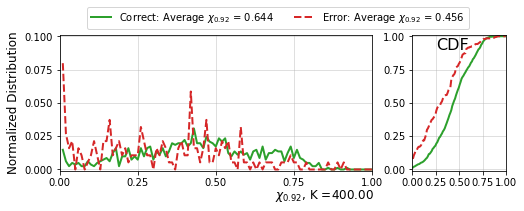

In [17]:
"""

Chose neighborhood index among neighborhood sizes and plot the spatial complexity
distribution given correct/incorrect per-submap label.

"""

neighborhood_index = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1, 0.3]},
    figsize = (8,2.5)
)

lw = 2
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)

ax1.set_xlim(0.0,1.0)
ax2.set_xlim(0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.25))
ax2.set_xticks(np.arange(0.0,1.1,0.25))

ax1.set_ylim(-0.001,0.101)
ax2.set_ylim(-0.01,1.01)
ax1.set_yticks(np.arange(0.0,0.11,0.025))
ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("Normalized Distribution", fontsize = 12)
ax2.text(
    x = 0.25, y = 0.9,
    s = "CDF", 
    fontsize = 16)

ax1.set_xlabel(
    "$\chi_{0.92}$"+", K ={:.2f}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    per_sample_low_norm[correct_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

incorrect_hist, incorrect_values = np.histogram(
    per_sample_low_norm[incorrect_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

correct_mean = np.mean(per_sample_low_norm[correct_interspace_labels_idxs,neighborhood_index+4])
correct_std = np.std(per_sample_low_norm[correct_interspace_labels_idxs,neighborhood_index+4])
incorrect_mean = np.mean(per_sample_low_norm[incorrect_interspace_labels_idxs,neighborhood_index+4])
incorrect_std = np.std(per_sample_low_norm[incorrect_interspace_labels_idxs,neighborhood_index+4])

ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average $\chi_{0.92}$'+' = {:.3f}'.format(correct_mean)
)

ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Error: Average $\chi_{0.92}$'+' = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:]-0.5*width,
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)

ax2.plot(
    correct_values[1:]-0.5*width,
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 10,
    bbox_to_anchor = (0.7, 1.125),
    loc = "center"
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

"""
plt.savefig(
    'properties/correct_vs_incorrect_low_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_low_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)
"""

Bar Plot for radius 2.0 and neighborhood size 400


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


"\nplt.savefig(\n    'properties/per_z_correct_vs_incorrect_low_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='pdf', dpi=300,bbox_inches = 'tight'\n)\n\nplt.savefig(\n    'properties/per_z_correct_vs_incorrect_low_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='png', dpi=300,bbox_inches = 'tight'\n)\n"

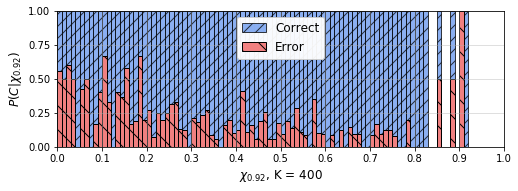

In [18]:
"""
Plot the posterior distribution: 
    probability of correct/incorrect given spatial complexity
    
"""

fig = plt.figure(figsize=(8,2.5))

ax1 = fig.add_subplot(111)

lw = 2
ax1.grid(alpha = 0.5)
#ax2.grid(alpha = 0.5)

ax1.set_xlim(-0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.10))
#ax2.set_xlim(-0.0,1.0)
#ax2.set_xticks(np.arange(0.0,1.1,0.25))

#ax1.set_ylim(-0.01,0.11)
ax1.set_ylim(-0.0,1.0)
#ax2.set_ylim(-0.0,1.0)
ax1.set_yticks(np.arange(0.0,1.01,0.25))
#ax1.set_yticks(np.arange(0.0,0.11,0.025))
#ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("$P(C|\chi_{0.92}$)", fontsize = 12)

ax1.set_xlabel(
    "$\chi_{0.92}$,"+" K = {}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
#ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist_total = correct_hist/(correct_hist + incorrect_hist)
incorrect_hist_total = incorrect_hist/(correct_hist + incorrect_hist)

ax1.bar(
    correct_values[1:]-0.5*width,
    correct_hist_total+incorrect_hist_total,
    width = width,
    color = 'cornflowerblue',
    alpha = 0.75,
    edgecolor='black', hatch='//',
    label = 'Correct'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(correct_mean)
);

ax1.bar(
    correct_values[1:]-0.5*width,
    incorrect_hist_total,
    width = width,
    color = 'lightcoral',
    #alpha = 0.75,
    edgecolor='black', hatch='\\',
    label = 'Error'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(incorrect_mean)
)

ax1.legend(
    ncol = 1,
    fontsize = 12,
    #bbox_to_anchor = (0.5, 1.1),
    loc = "upper center",
    framealpha = 0.95
)

print('Bar Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

"""
plt.savefig(
    'properties/per_z_correct_vs_incorrect_low_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/per_z_correct_vs_incorrect_low_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)
"""

# On pointnetvlad over HoloLens data

In [19]:
with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(2.0), 'r') as bz2_f:
    norm_cdf_values = pickle.load(bz2_f)
    
pv_per_sample_low_norm = []

for [obj_, object_name, original_vertex], per_space_values in norm_cdf_values:
    
    #if obj_ != 2: continue
    if object_name == "Reception-Data61-L5.obj":
        new_vX = original_vertex[0] + 50
        new_vZ = original_vertex[2] + 0
    elif object_name == "Driveway.obj":
        new_vX = original_vertex[0] - 25
        new_vZ = original_vertex[2] - 50
    elif object_name == "Apartment.obj":
        new_vX = original_vertex[0] + 25
        new_vZ = original_vertex[2] - 50
    elif object_name == "Workstations-Data61-L4.obj":
        new_vX = original_vertex[0] - 50
        new_vZ = original_vertex[2] + 0
    elif object_name == "Kitchen-Data61-L4.obj":
        new_vX = original_vertex[0] + 0
        new_vZ = original_vertex[2] + 0
    elif object_name == "HallWayToKitchen-Data61-L4.obj":
        new_vX = original_vertex[0] - 25
        new_vZ = original_vertex[2] + 50
    elif object_name == "StairWell-Data61-L4.obj":
        new_vX = original_vertex[0] + 25
        new_vZ = original_vertex[2] + 50
    else:
        print("Error:",obj_meta)
    
    norm_cdf_ratios = [
        obj_,
        new_vX,
        original_vertex[1],
        new_vZ
    ]
    
    for hist, CY, values, hist_all, values_all, neighbor_size, len__ in per_space_values:
        
        np.sum(hist*values[1:])/np.sum(hist)
        
        norm_cdf_ratios.append(
            #neighbor_size,
            np.sum(hist[:92])/np.sum(hist)
            #np.sum(hist[95:])/np.sum(hist)
            #np.sum(hist_all[:80])/np.sum(hist_all[80:-1]),
            #np.sum(hist_all[80:-1])/np.sum(hist_all[:80]),
            #np.sum(hist*values[1:])/np.sum(hist)
            #np.sum(hist[50:])/np.sum(hist[:50]),
        )
        
    pv_per_sample_low_norm.append(norm_cdf_ratios)
    
pv_per_sample_low_norm = np.asarray(pv_per_sample_low_norm)


In [20]:
#fig = plt.figure(figsize=(8,2))

radius = 2.0

RESULTS_FOLDER="testing_results/pointnetvlad_prod_2/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs_2_0.5.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")

errors_pool = []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    if radius != 2.0: continue
    
    for m, n, top1_obj_cands in test_recall:
        
        """
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
        """
        
        for original_vertex, orig_label, cand_label in top1_obj_cands:
            
            #print(radius, m ,n, original_vertex, orig_label, cand_label)

            per_obj_label = []
            per_obj_label.append(orig_label)
            per_obj_label.append(cand_label)
            per_obj_label.append(original_vertex[0])
            per_obj_label.append(original_vertex[1])
            per_obj_label.append(original_vertex[2])
            errors_pool.append(per_obj_label)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    break
    
pv_partial_errors_pool = np.asarray(errors_pool)
    
pv_correct_interspace_labels_idxs = np.where(pv_partial_errors_pool[:,1]==pv_partial_errors_pool[:,0])[0]

pv_incorrect_interspace_labels_idxs = np.where(pv_partial_errors_pool[:,1]!=pv_partial_errors_pool[:,0])[0]

pv_partial_errors_pool.shape, pv_correct_interspace_labels_idxs.shape, pv_incorrect_interspace_labels_idxs.shape

((2000, 5), (1644,), (356,))

Plot for radius 2.0 and neighborhood size 400


"\nplt.savefig(\n    'properties/correct_vs_incorrect_low_pv_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='pdf', dpi=300,bbox_inches = 'tight'\n)\n\nplt.savefig(\n    'properties/correct_vs_incorrect_low_pv_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='png', dpi=300,bbox_inches = 'tight'\n)\n"

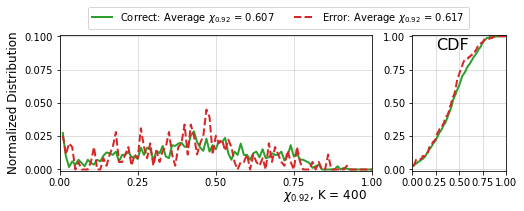

In [22]:

fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1, 0.3]},
    figsize = (8,2.5)
)

lw = 2
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)

ax1.set_xlim(0.0,1.0)
ax2.set_xlim(0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.25))
ax2.set_xticks(np.arange(0.0,1.1,0.25))

ax1.set_ylim(-0.001,0.101)
ax2.set_ylim(-0.01,1.01)
ax1.set_yticks(np.arange(0.0,0.11,0.025))
ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("Normalized Distribution", fontsize = 12)
ax2.text(
    x = 0.25, y = 0.9,
    s = "CDF", 
    fontsize = 16)

ax1.set_xlabel(
    "$\chi_{0.92}$"+", K = {}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)

ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    pv_per_sample_low_norm[pv_correct_interspace_labels_idxs%1000,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

incorrect_hist, incorrect_values = np.histogram(
    pv_per_sample_low_norm[pv_incorrect_interspace_labels_idxs%1000,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

correct_mean = np.mean(pv_per_sample_low_norm[pv_correct_interspace_labels_idxs%1000,neighborhood_index+4])
incorrect_mean = np.mean(pv_per_sample_low_norm[pv_incorrect_interspace_labels_idxs%1000,neighborhood_index+4])

ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average $\chi_{0.92}$'+' = {:.3f}'.format(correct_mean)
)
ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Error: Average $\chi_{0.92}$'+' = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:],
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)
ax2.plot(
    incorrect_values[1:],
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 10,
    bbox_to_anchor = (0.7, 1.125),
    loc = "center"
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

"""
plt.savefig(
    'properties/correct_vs_incorrect_low_pv_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_low_pv_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)
"""


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Plot for radius 2.0 and neighborhood size 400


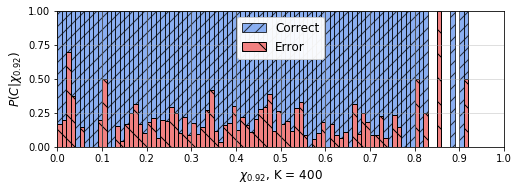

In [23]:
# Posterior

fig = plt.figure(figsize=(8,2.5))

ax1 = fig.add_subplot(111)

lw = 2
ax1.grid(alpha = 0.5)
#ax2.grid(alpha = 0.5)

ax1.set_xlim(-0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.10))
#ax2.set_xlim(-0.0,1.0)
#ax2.set_xticks(np.arange(0.0,1.1,0.25))

#ax1.set_ylim(-0.01,0.11)
ax1.set_ylim(-0.0,1.0)
#ax2.set_ylim(-0.0,1.0)
ax1.set_yticks(np.arange(0.0,1.01,0.25))
#ax1.set_yticks(np.arange(0.0,0.11,0.025))
#ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("$P(C|\chi_{0.92}$)", fontsize = 12)

ax1.set_xlabel(
    "$\chi_{0.92}$"+", K = {}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)

correct_hist_total = correct_hist/(correct_hist + incorrect_hist)
incorrect_hist_total = incorrect_hist/(correct_hist + incorrect_hist)

ax1.bar(
    correct_values[1:]-0.5*width,
    correct_hist_total+incorrect_hist_total,
    width = width,
    color = 'cornflowerblue',
    alpha = 0.75,
    edgecolor='black', hatch='//',
    label = 'Correct'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(correct_mean)
);

ax1.bar(
    correct_values[1:]-0.5*width,
    incorrect_hist_total,
    width = width,
    color = 'lightcoral',
    #alpha = 0.75,
    edgecolor='black', hatch='\\',
    label = 'Error'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(incorrect_mean)
)

#"""
ax1.legend(
    ncol = 1,
    fontsize = 12,
    #bbox_to_anchor = (0.5, 1.1),
    loc = "upper center",
    framealpha = 0.95
)
#"""

"""
plt.savefig(
    'properties/per_z_correct_vs_incorrect_low_pv_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/per_z_correct_vs_incorrect_low_pv_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)
"""

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))


# On NN-Matcher over ARCore spatial data

In [31]:

try:
    with bz2.BZ2File("testing_results/nn_matcher_arcore/{}_partial_scores.pickle.bz2".format(radius), 'r') as bz2_f:
        partial_scores_pool = pickle.load(bz2_f) 

except:
    print("Error getting arcore scores for",radius)

partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, arcore_descriptors[:-1])
arcore_correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
arcore_incorrect_interspace_labels_idxs = np.where(partial_errors_pool[:,1]!=0)[0]
#pv_incorrect_interspace_labels_idxs = np.where(pv_partial_errors_pool[:,1]!=pv_partial_errors_pool[:,0])[0]


In [24]:
with open("testing_results/nn_matcher_arcore/{}_partial_sim_hist.pickle".format(2.0), 'rb') as f:
    norm_cdf_values = pickle.load(f)
    
arcore_per_sample_low_norm = []

for [obj_, object_name, original_vertex], per_space_values in norm_cdf_values:
    
    #if obj_ != 2: continue
    
    norm_cdf_ratios = [
        obj_,
        original_vertex[0],
        original_vertex[1],
        original_vertex[2]
    ]
    
    for hist, CY, values, hist_all, values_all, neighbor_size, len__ in per_space_values:
        
        np.sum(hist*values[1:])/np.sum(hist)
        
        norm_cdf_ratios.append(
            #neighbor_size,
            np.sum(hist_all[:95])/np.sum(hist_all)
            #np.sum(hist_all[:80])/np.sum(hist_all[80:-1]),
            #np.sum(hist_all[80:-1])/np.sum(hist_all[:80]),
            #np.sum(hist*values[1:])/np.sum(hist)
            #np.sum(hist[50:])/np.sum(hist[:50]),
        )
        
    arcore_per_sample_low_norm.append(norm_cdf_ratios)
    
arcore_per_sample_low_norm = np.asarray(arcore_per_sample_low_norm)


Plot for radius 2.0 and neighborhood size 400


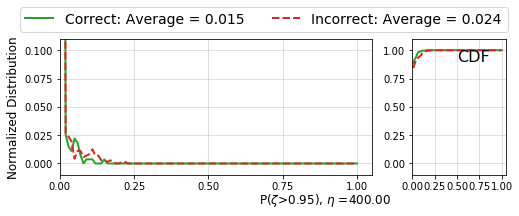

In [33]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1, 0.3]},
    figsize = (8,2.5)
)

lw = 2
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)

ax1.set_xlim(0.0,1.05)
ax2.set_xlim(0.0,1.05)
ax1.set_xticks(np.arange(0.0,1.1,0.25))
ax2.set_xticks(np.arange(0.0,1.1,0.25))

ax1.set_ylim(-0.01,0.11)
ax2.set_ylim(-0.1,1.1)
ax1.set_yticks(np.arange(0.0,0.11,0.025))
ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("Normalized Distribution", fontsize = 12)
ax2.text(
    x = 0.5, y = 0.9,
    s = "CDF", 
    fontsize = 16)

ax1.set_xlabel(
    "P($\zeta$>0.95), $\eta$ ={:.2f}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    arcore_per_sample_low_norm[arcore_correct_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

incorrect_hist, incorrect_values = np.histogram(
    arcore_per_sample_low_norm[arcore_incorrect_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

correct_mean = np.mean(arcore_per_sample_low_norm[arcore_correct_interspace_labels_idxs,neighborhood_index+4])
incorrect_mean = np.mean(arcore_per_sample_low_norm[arcore_incorrect_interspace_labels_idxs,neighborhood_index+4])

ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average = {:.3f}'.format(correct_mean)
)
ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect: Average = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:],
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)
ax2.plot(
    incorrect_values[1:],
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 14,
    bbox_to_anchor = (-0.15, 1.0),
    loc = "lower left"
)

#correct_mean, incorrect_mean

plt.savefig(
    'properties/correct_vs_incorrect_nn_arcore_low_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_nn_arcore_low_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

# Scratch

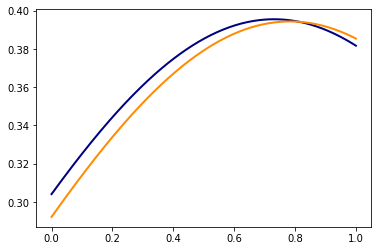

In [179]:
# Attempt at KDE

from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

correct_est = per_sample_high_norm[correct_interspace_labels_idxs,4,np.newaxis]

incorrect_est = per_sample_high_norm[incorrect_interspace_labels_idxs,4,np.newaxis]

# Gaussian KDE

"""
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")
"""
bins = np.linspace(0,1,200)[:, np.newaxis]

c_kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(correct_est)

log_dens = c_kde.score_samples(bins)

plt.plot(
    bins[:, 0], 
    np.exp(log_dens), 
    color='navy',
    lw=2,
    linestyle='-', 
    label="correct"
)

ic_kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(incorrect_est)

log_dens = ic_kde.score_samples(bins)

plt.plot(
    bins[:, 0], 
    np.exp(log_dens), 
    color='darkorange',
    lw=2,
    linestyle='-', 
    label="incorrect"
)

188

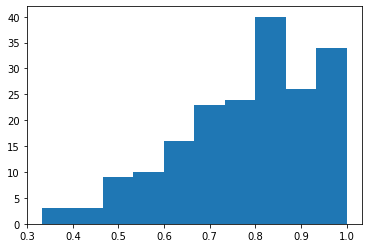

In [141]:
incorrect_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==1)[0]

plt.hist(per_sample_high_norm[incorrect_interspace_labels_idxs,4])

len(incorrect_interspace_labels_idxs)

((133, 6), (133, 4))

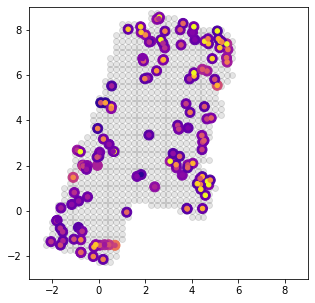

In [205]:

fig = plt.figure(figsize=(5,5))

obj__, point_cloud, triangles = new_contiguous_point_collection[2]

obj__, point_cloud.shape, triangles.shape

floor_pointcloud = 0.25*100*np.around((0.01/0.25)*point_cloud[:,[0,2]],decimals=2)
unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)

X = floor_pointcloud[:,0]
Z = floor_pointcloud[:,1]

plt.xlim(-3,9)
plt.ylim(-3,9)

plt.scatter(
    unq_floor_pointcloud[:,0],
    unq_floor_pointcloud[:,1],
    color = 'black',
    alpha = 0.1
)

plt.scatter(
    per_sample_norm_cdf[indices[:,0],0],
    per_sample_norm_cdf[indices[:,0],2],
    c = per_sample_norm_cdf[indices[:,0],5],
    s = 100.0,
    #norm = True,
    vmin = 0, vmax = 2.0,
    cmap = plt.cm.plasma
)

plt.scatter(
    x = good_spaces[:,0],
    y = good_spaces[:,2],
    c = good_spaces[:,3],
    s = 20.0,
    #norm = True,
    vmin = 0, vmax = 2.0,
    cmap = plt.cm.plasma
)

#plt.colorbar()
per_sample_norm_cdf[indices[:,0]].shape, good_spaces.shape

((133, 6), (133, 4))

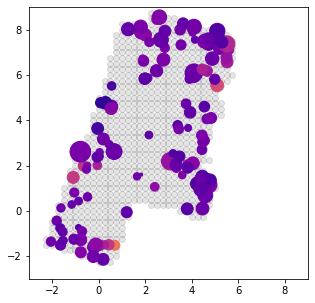

In [206]:

fig = plt.figure(figsize=(5,5))

obj__, point_cloud, triangles = new_contiguous_point_collection[2]

obj__, point_cloud.shape, triangles.shape

floor_pointcloud = 0.25*100*np.around((0.01/0.25)*point_cloud[:,[0,2]],decimals=2)
unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)

X = floor_pointcloud[:,0]
Z = floor_pointcloud[:,1]

plt.xlim(-3,9)
plt.ylim(-3,9)

plt.scatter(
    unq_floor_pointcloud[:,0],
    unq_floor_pointcloud[:,1],
    color = 'black',
    alpha = 0.1
)

plt.scatter(
    per_sample_norm_cdf[indices[:,0],0],
    per_sample_norm_cdf[indices[:,0],2],
    c = per_sample_norm_cdf[indices[:,0],5],
    s =  good_spaces[:,3]*100,
    #norm = True,
    vmin = 0, vmax = 2.0,
    cmap = plt.cm.plasma
)

#plt.colorbar()
per_sample_norm_cdf[indices[:,0]].shape, good_spaces.shape

array([[ 1.        , -0.09740766],
       [-0.09740766,  1.        ]])

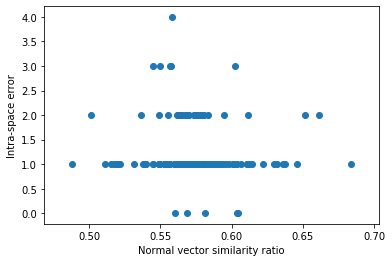

In [30]:
plt.scatter(
    per_sample_norm_cdf[indices[:,0],5],
    np.around(good_spaces[:,3], decimals = 0),
)
plt.ylabel("Intra-space error")
plt.xlabel("Normal vector similarity ratio")

np.corrcoef(
    per_sample_norm_cdf[indices[:,0],5],
    good_spaces[:,3]
)

array([[1.        , 0.16784513],
       [0.16784513, 1.        ]])

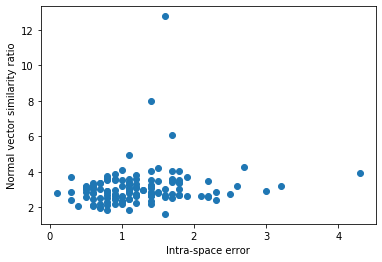

In [35]:
plt.scatter(
    np.around(good_spaces[:,3], decimals = 1),
    per_sample_norm_cdf[indices[:,0],5],
)
plt.xlabel("Intra-space error")
plt.ylabel("Normal vector similarity ratio")

np.corrcoef(
    per_sample_norm_cdf[indices[:,0],5],
    good_spaces[:,3]
)

(array([ 7., 38., 37., 32.,  8.,  6.,  2.,  2.,  0.,  1.]),
 array([0.09388551, 0.51053057, 0.92717563, 1.3438207 , 1.76046576,
        2.17711082, 2.59375588, 3.01040094, 3.427046  , 3.84369107,
        4.26033613]),
 <a list of 10 Patch objects>)

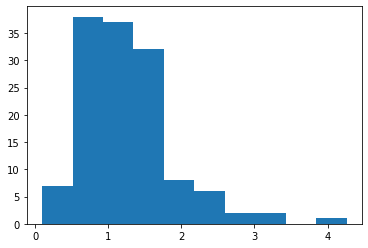

In [28]:
plt.hist(good_spaces[:,3])